In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
from collections import Counter

### Read data

In [2]:
raw = pd.read_csv('./filtered_helpfulness.csv')

### Flatten data

In [3]:
data = []
for i,row in raw.iterrows():
    for j in range(1, 13):
        query = row['Input.q%d' % j]
        response = row['Input.r%d' % j]
        gender = row['Input.g%d' % j]
        
        if row['Answer.answer%d' % j] is not np.nan:
            answer = row['Answer.answer%d' % j]
        else:
            answer = row['Answer.answer%d.label' % j]
        
        data.append((row['HITId'], j, row['WorkerId'], gender, query, response, answer))

In [4]:
melted = pd.DataFrame(data)
melted.columns = ['HITId', 'q_idx', 'WorkerId', 'gender', 'query', 'response', 'answer']

In [5]:
# include spammers:
include = True
if not include:
    spammers = ['A3A0RP6IUR41PP']
    melted = melted[~melted.WorkerId.isin(spammers)].copy()

In [6]:
data = []
for i, group in melted.groupby(['HITId', 'q_idx']):
    row = []
    row.append(group.iloc[0]['HITId'])
    row.append(group.iloc[0]['gender'])
    row.append(group.iloc[0]['query'])
    row.append(group.iloc[0]['response'])
    for j in range(0,5):
        if j < len(group):
            row.append(group.iloc[j]['WorkerId'])
            row.append(group.iloc[j]['answer'])
    data.append(row)

In [7]:
flat = pd.DataFrame(data)
flat.columns = ['HITId', 'gender', 'query', 'response'] + \
    sum([ ['WorkerId%d' % i, 'answer%d' % i] for i in range(0,5) ], [])

In [8]:
flat.head(1)

,HITId,gender,query,response,WorkerId0,answer0,WorkerId1,answer1,WorkerId2,answer2,WorkerId3,answer3,WorkerId4,answer4
0,30OITAWPBQ4YB0SP96MMQOOHX7T9HP,W,Who the fuck demands their partner lose weight...,You have to ask?,A12JKMVUW5HNKO,Response provides some information to the ques...,AA5ZDXAA2DLY1,Response provides no information to the questi...,A1ET2J1PIP0RGO,Response provides no information to the questi...,A32W24TWSWXW,Response provides no information to the questi...,AFIK3VBMMX6G6,Response provides no information to the questi...


### Collapse labels

In [9]:
flat.answer0.unique()

array(['Response provides some information to the question',
       'Response satisfactorily answers the question',
       'Response provides no information to the question at all',
       'Response does not make sense'], dtype=object)

In [10]:
def i_no_i(x):
    if 'Response satisfactorily' in x:
        return 'i'
    elif 'provides some' in x:
        return 'i'
    elif 'does not make sense' in x:
        return 'ni'
    elif 'provides no' in x:
        return 'ni'

### Interannotator agreement

In [11]:
order = ['Response satisfactorily answers the question', 'Response provides some information to the question', 'Response provides no information to the question at all', 'Response does not make sense']
order = ['i', 'ni']
ls = []

for i, row in flat.iterrows():
    labels = [ row['answer%d' %i ] for i in range(0, 5) ]
    labels = list(map(i_no_i, labels))
    unique, counts = np.unique(labels,return_counts=True)
    unique = unique.tolist()
    
    l = []
    for i in order:
        if i in unique:   
            idx = unique.index(i)
            count = counts[idx]
        else:
            count = 0
        l.append(str(count))
        ls.append(l)
    #print('\t'.join(l))

In [12]:
# number of near agreements
np.mean([ '3' in i for i in ls ])

0.4

collapsed:
62.67%
Kappa: 0.25

### Majority labels

In [13]:
def majority(x, collapse=i_no_i, n=5):
    labels = [ x['answer%d' % i] for i in range(0, n)]
    labels = [ i for i in labels if i ]
    labels = list(map(collapse, labels))
    
    c = Counter(labels)
    commons = c.most_common(2)
    
    if len(commons) > 1 and commons[0][1] == commons[1][1]:
        return 'tie'
    else:
        return commons[0][0]

def near_majority(x, collapse=i_no_i, n=5):
    labels = [ x['answer%d' % i] for i in range(0, n)]
    labels = [ i for i in labels if i ]
    labels = list(map(collapse, labels))
    
    c = Counter(labels)
    commons = c.most_common(2)
    
    return commons[0][1] == 3

In [14]:
flat['binary_majority'] = flat.apply(majority, axis=1)
flat['near_majority'] = flat.apply(near_majority, axis=1)
flat['majority'] = flat.apply(lambda x: majority(x, collapse=lambda x:x), axis=1)

### Analysis

In [15]:
for i, group in flat.groupby('gender'):
    print(i)
    print(group.majority.value_counts(normalize=True))

M
tie                                                        0.366197
Response satisfactorily answers the question               0.352113
Response provides some information to the question         0.140845
Response provides no information to the question at all    0.126761
Response does not make sense                               0.014085
Name: majority, dtype: float64
W
Response satisfactorily answers the question               0.489796
tie                                                        0.224490
Response provides no information to the question at all    0.122449
Response does not make sense                               0.102041
Response provides some information to the question         0.061224
Name: majority, dtype: float64


In [16]:
for i, group in flat[~flat.near_majority].groupby('gender'):
    print(i)
    print(group.binary_majority.value_counts(normalize=True))

M
i     0.842105
ni    0.157895
Name: binary_majority, dtype: float64
W
i     0.735294
ni    0.264706
Name: binary_majority, dtype: float64


### Identifying spammers

In [17]:
for i, group in melted.groupby('WorkerId'):
    print('WorkerId: %s' % i)
    print(group.answer.value_counts())
    print()

WorkerId: A12JKMVUW5HNKO
Response provides some information to the question         48
Response satisfactorily answers the question               47
Response provides no information to the question at all    13
Response does not make sense                               12
Name: answer, dtype: int64

WorkerId: A1ET2J1PIP0RGO
Response satisfactorily answers the question               69
Response provides no information to the question at all    14
Response provides some information to the question         12
Response does not make sense                                1
Name: answer, dtype: int64

WorkerId: A20IA63WXHF683
Response provides no information to the question at all    6
Response provides some information to the question         4
Response does not make sense                               2
Name: answer, dtype: int64

WorkerId: A2ARIPM4X6WZAK
Response satisfactorily answers the question               37
Response does not make sense                               15
Response prov

In [18]:
spammers = ['A3A0RP6IUR41PP']

### Qualitative analysis

In [19]:
flat[['gender', 'binary_majority', 'query', 'response']][flat.binary_majority == 'i'].sample(20)

,gender,binary_majority,query,response
5,W,i,How is your relationship with your mom?,She's a great lady. I'm not too sure what she'...
69,M,i,How is maybe tampering and not turning over a ...,"He's not talking about him, he's talking about..."
118,M,i,Who was charged as a result of those investiga...,The police
96,M,i,How about loaning us a bit of the playoffs moj...,I can't even imagine what a few of us would do...
116,M,i,What the fuck are you lmaoing about?,I think he's saying he's the same height as th...
43,M,i,How does their potential down the road have an...,Because they have a great record of getting to...
42,W,i,What about the health of his children?,They are in great health.
95,M,i,When was the last time you drew your whole dec...,This is my first time.
79,W,i,How do you both divide up middle of the night ...,My mom is a nurse and my dad is a nurse.
98,M,i,Whats going to happen if bitcoin or gold ever ...,It'll be like the housing market crash of 2000.


In [20]:
flat[['gender', 'binary_majority', 'query', 'response']][flat.binary_majority == 'ni'].sample(20)

,gender,binary_majority,query,response
109,W,ni,What is so offensive about that?,I don't think you know what's offensive about ...
33,M,ni,What is at the core of our state really?,I think it's a lot more than a core.
117,M,ni,What more could you ask for in terms of support?,"I have no idea, but I'd like it to be a little..."
54,M,ni,Whens the last time that happened to a cyclist?,When was the last time a cyclist got run over?
84,W,ni,How can you be so inconsiderate??,I'm sorry. But the question is...
62,M,ni,Whats a solid upper-mid quad core from team red?,I'll PM you!
34,M,ni,"How about absolutely, irretrievably denying so...",I think that's a better idea.
92,M,ni,What the fuck did you just fucking say about m...,I love when he says that.
24,M,ni,How has the EU withstood the financial crisis ...,China and the U. S. have been doing just fine.
30,W,ni,What do you think happens to those poorly taug...,They die.


In [21]:
pd.set_option('max_colwidth', 100)
flat[['gender', 'binary_majority', 'query', 'response']][(flat.gender == 'M') & (flat.binary_majority != 'i')]

,gender,binary_majority,query,response
12,M,ni,"What if I could prove to you beyond the shadow of a doubt, with tons of evidence that nobody inv...","I'm not sure I understand why that would be a good thing, but whatever you say."
24,M,ni,How has the EU withstood the financial crisis better that China or the U.S.?,China and the U. S. have been doing just fine.
29,M,ni,Whats a solid upper-mid quad core from team red?,That's what I use.
33,M,ni,What is at the core of our state really?,I think it's a lot more than a core.
34,M,ni,"How about absolutely, irretrievably denying someone access to their commander?",I think that's a better idea.
54,M,ni,Whens the last time that happened to a cyclist?,When was the last time a cyclist got run over?
62,M,ni,Whats a solid upper-mid quad core from team red?,I'll PM you!
83,M,ni,What are you referring to exactly?,I think he means the''...''...''.............?
92,M,ni,"What the fuck did you just fucking say about me, you little bitch?",I love when he says that.
93,M,ni,"When hes just relaxing and watching tv, guess what?",I'm going to go out on a limb and assume you're a guy.


In [22]:
flat[['gender', 'binary_majority', 'query', 'response']][(flat.gender == 'W') & (flat.binary_majority != 'i')]

,gender,binary_majority,query,response
0,W,ni,Who the fuck demands their partner lose weight by a specific deadline?,You have to ask?
2,W,ni,How would I tell my family?,How would I tell my family?
11,W,ni,How do you both divide up middle of the night feedings and changing?,I just use google sheets.
19,W,ni,What if you guys have a pregnancy scare?,I'm going to go with no.
30,W,ni,What do you think happens to those poorly taught obese children?,They die.
41,W,ni,What is the points of being fiancees if youre not actually getting married?,"If you have a wife, you are not married."
46,W,ni,"When *wasnt* American society polarized, though?",When was the last time you were in a meeting?
65,W,ni,whats your plan for the dog when you move out of your parents house?,I think we're going to try to get him a job or something.
76,W,ni,What the fuck was wrong with me?,"You were a child, and your parents were a child."
80,W,ni,What bank on earth doesnt show all transactions?,I've never seen it.


In [23]:
flat[['gender', 'near_majority', 'binary_majority', 'query', 'response']][(flat.near_majority)]

,gender,near_majority,binary_majority,query,response
1,W,True,i,How would you feel if you dated a guy for a *significant* period of time and then have your best...,"I'd feel like a loser, he'd be a loser, he'd be a loser, he'd be a loser, he'd be a loser"
7,M,True,i,"How about the Sjah of Iran, who was a despot and a dictator who ruled with an iron fist, jailed ...",I'm sure that's what the Russians were thinking too.
11,W,True,ni,How do you both divide up middle of the night feedings and changing?,I just use google sheets.
12,M,True,ni,"What if I could prove to you beyond the shadow of a doubt, with tons of evidence that nobody inv...","I'm not sure I understand why that would be a good thing, but whatever you say."
14,W,True,i,When did being rude and tearing people down become an admirable character trait?,It's a character trait.
15,W,True,i,How does a person not know the name of their spouses deceased spouse?,"I'm not sure, but I would imagine that it's a common name among people living in the same country."
16,M,True,i,What free content do you think /DRIVE will still have that will be good enough to really get the...,I'm not sure. I think it's probably a good idea to ask the devs.
17,W,True,i,How about we push X plan off to next saturday instead of tomorrow?,I'm not sure how to push it off. : s
18,M,True,i,"What about researching a market, developing a plan, seeking out investors, building capital, cre...",That's a lot of work.
20,M,True,i,How many times have you bought a game on Steam during a sale and been *completely unable* to dow...,I've bought a few games on steam. I have not bought anything on steam.


### Statistical analysis

In [24]:
trials = []
for i in range(0, 1000): 
    shuffle = flat['gender'].copy()
    np.random.shuffle(shuffle)
    
    flat['permute'] = shuffle
    pt = list(flat.groupby('permute'))
    
    g1, g2 = pt[0][1], pt[1][1]
    
    t = np.sum(g1.binary_majority.value_counts(normalize=True)['i']) - np.sum(g2.binary_majority.value_counts(normalize=True)['i'])
    trials.append(t)

sns.distplot(trials)

KeyboardInterrupt: 

In [ ]:
trials = np.array(trials)
np.mean(trials >= 0.0744)

In [ ]:
flat[['query', 'response']].to_csv('query_response.tsv', sep='\t', header=None, index=False)

### Near majorities analysis

In [76]:
solid_majorities = flat[~flat.near_majority].copy()
pd.DataFrame(solid_majorities.groupby('gender').binary_majority.value_counts(normalize=True))

binary_majority
gender binary_majority                 
M      i                       0.842105
       ni                      0.157895
W      i                       0.735294
       ni                      0.264706

In [79]:
solid_majorities

,HITId,gender,query,response,WorkerId0,answer0,WorkerId1,answer1,WorkerId2,answer2,WorkerId3,answer3,WorkerId4,answer4,binary_majority,near_majority,majority,permute
0,30OITAWPBQ4YB0SP96MMQOOHX7T9HP,W,Who the fuck demands their partner lose weight by a specific deadline?,You have to ask?,A12JKMVUW5HNKO,Response provides some information to the question,AA5ZDXAA2DLY1,Response provides no information to the question at all,A1ET2J1PIP0RGO,Response provides no information to the question at all,A32W24TWSWXW,Response provides no information to the question at all,AFIK3VBMMX6G6,Response provides no information to the question at all,ni,False,Response provides no information to the question at all,None
2,30OITAWPBQ4YB0SP96MMQOOHX7T9HP,W,How would I tell my family?,How would I tell my family?,A12JKMVUW5HNKO,Response provides no information to the question at all,AA5ZDXAA2DLY1,Response provides no information to the question at all,A1ET2J1PIP0RGO,Response provides no information to the question at all,A32W24TWSWXW,Response provides no information to the question at all,AFIK3VBMMX6G6,Response does not make sense,ni,False,Response provides no information to the question at all,None
3,30OITAWPBQ4YB0SP96MMQOOHX7T9HP,W,What ideology did you assume I was?,The best one!,A12JKMVUW5HNKO,Response provides some information to the question,AA5ZDXAA2DLY1,Response provides some information to the question,A1ET2J1PIP0RGO,Response satisfactorily answers the question,A32W24TWSWXW,Response provides no information to the question at all,AFIK3VBMMX6G6,Response provides some information to the question,i,False,Response provides some information to the question,None
4,30OITAWPBQ4YB0SP96MMQOOHX7T9HP,W,Who cares what you friends think?,I don't care what you friends think.,A12JKMVUW5HNKO,Response satisfactorily answers the question,AA5ZDXAA2DLY1,Response provides some information to the question,A1ET2J1PIP0RGO,Response satisfactorily answers the question,A32W24TWSWXW,Response satisfactorily answers the question,AFIK3VBMMX6G6,Response provides some information to the question,i,False,Response satisfactorily answers the question,None
5,30OITAWPBQ4YB0SP96MMQOOHX7T9HP,W,How is your relationship with your mom?,"She's a great lady. I'm not too sure what she's doing with her life, but I do love her.",A12JKMVUW5HNKO,Response satisfactorily answers the question,AA5ZDXAA2DLY1,Response satisfactorily answers the question,A1ET2J1PIP0RGO,Response satisfactorily answers the question,A32W24TWSWXW,Response satisfactorily answers the question,AFIK3VBMMX6G6,Response provides some information to the question,i,False,Response satisfactorily answers the question,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,3W1K7D6QSBI3QE7GDC6PH1NCHXDBZR,M,Whats going on with the training or Police in Minnesota?,What do you mean? What are you asking?,A2ZK5I1MDWNPRU,Response provides no information to the question at all,A12JKMVUW5HNKO,Response provides no information to the question at all,A32W24TWSWXW,Response provides no information to the question at all,AFIK3VBMMX6G6,Response provides some information to the question,A2CQP20O9KH1TZ,Response does not make sense,ni,False,Response provides no information to the question at all,None
113,3W1K7D6QSBI3QE7GDC6PH1NCHXDBZR,W,how often have you seen a girl legit not read a text?,Not that much,A2ZK5I1MDWNPRU,Response satisfactorily answers the question,A12JKMVUW5HNKO,Response does not make sense,A32W24TWSWXW,Response satisfactorily answers the question,AFIK3VBMMX6G6,Response provides some information to the question,A2CQP20O9KH1TZ,Response satisfactorily answers the question,i,False,Response satisfactorily answers the question,None
114,3W1K7D6QSBI3QE7GDC6PH1NCHXDBZR,W,What do you all think was the point of that scene?,"I thought it was to show a bit of humanity and not to show how evil or evil people can be, I gue...",A2ZK5I1MDWNPRU,Response satisfactorily answers the question,A12JKMVUW5HNKO,Response satisfactorily a

/nas/home/jwei/anaconda3/envs/notebook/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/nas/home/jwei/anaconda3/envs/notebook/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


<AxesSubplot:ylabel='Density'>

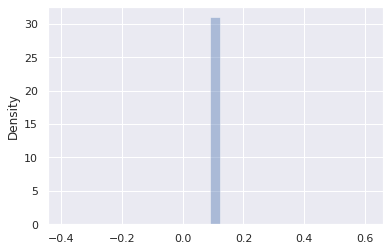

In [84]:
trials = []
for i in range(0, 1000): 
    shuffle = solid_majorities.gender.copy()
    np.random.shuffle(shuffle.reset_index(drop=True))
    
    solid_majorities['permute'] = shuffle
    pt = list(solid_majorities.groupby('permute'))

    g1, g2 = pt[0][1], pt[1][1]
    
    try:
        v1 = g1.binary_majority.value_counts(normalize=True)['i']
    except:
        v1 = 0
        
    try:
        v2 = g2.binary_majority.value_counts(normalize=True)['i']
    except:
        v2 = 0
    
    t = np.sum(v1) - np.sum(v2)
    trials.append(t)

sns.distplot(trials)

In [ ]:
trials = np.array(trials)
np.mean(trials >= 0.0744)

In [56]:
# does near majority add random noise?
flat[flat.near_majority].groupby('gender').binary_majority.value_counts()

gender  binary_majority
M       i                  24
        ni                  9
W       i                  10
        ni                  5
Name: binary_majority, dtype: int64